# EDA) 

### In order to explore the data, we first need to clean it. Inspecting the initial datasets show some different features between the years (ex: Social Support data only present in 2018-2019), so we will only choose features that are present in all of the datasets. After renaming and dropping appropriate features, we finally concatenate the data together (By Cesare Lucido). 

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge

In [31]:
# assign a new "Year" feature to each entry upon load
fifteenData = pd.read_csv("world_happiness/2015.csv").assign(Year=2015)
sixteenData = pd.read_csv("world_happiness/2016.csv").assign(Year=2016)
seventeenData = pd.read_csv("world_happiness/2017.csv").assign(Year=2017)
eighteenData = pd.read_csv("world_happiness/2018.csv").assign(Year=2018)
nineteenData = pd.read_csv("world_happiness/2019.csv").assign(Year=2019)

In [32]:
# Formatting 2015 data and other years to:
# Country | Rank | Score | GDP per Capita | Life Expectancy | Freedom | Trust | Generosity | Year
fifteenData.rename(columns={
    "Happiness Rank": "Rank",
    "Happiness Score": "Score",
    "Economy (GDP per Capita)": "GDP per Capita",
    "Health (Life Expectancy)": "Life Expectancy",
    "Trust (Government Corruption)": "Trust"
},inplace=True)
fifteenData.drop(['Region', 'Standard Error', 'Family', 'Dystopia Residual'], axis=1, inplace=True)

In [33]:
# Formatting 2016 data
sixteenData.rename(columns={
    "Happiness Rank": "Rank",
    "Happiness Score": "Score",
    "Economy (GDP per Capita)": "GDP per Capita",
    "Health (Life Expectancy)": "Life Expectancy",
    "Trust (Government Corruption)": "Trust"
},inplace=True)
sixteenData.drop(['Region', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Family', 'Dystopia Residual'], axis=1, inplace=True)

In [34]:
# Formatting 2017 data
seventeenData.rename(columns={
    "Happiness.Rank": "Rank",
    "Happiness.Score": "Score",
    "Economy..GDP.per.Capita.": "GDP per Capita",
    "Health..Life.Expectancy.": "Life Expectancy",
    "Trust..Government.Corruption.": "Trust"
},inplace=True)
seventeenData.drop(['Whisker.high', 'Whisker.low', 'Family', 'Dystopia.Residual'], axis=1, inplace=True)

In [35]:
# Formatting 2018 data
eighteenData.rename(columns={
    "Overall rank": "Rank",
    "Country or region": "Country",
    "Freedom to make life choices": "Freedom",
    "GDP per capita": "GDP per Capita",
    "Healthy life expectancy": "Life Expectancy",
    "Perceptions of corruption": "Trust"
},inplace=True)
eighteenData.drop(['Social support'], axis=1, inplace=True)

In [36]:
# Formatting 2019 data
nineteenData.rename(columns={
    "Overall rank": "Rank",
    "Country or region": "Country",
    "Freedom to make life choices": "Freedom",
    "GDP per capita": "GDP per Capita",
    "Healthy life expectancy": "Life Expectancy",
    "Perceptions of corruption": "Trust"
},inplace=True)
nineteenData.drop(['Social support'], axis=1, inplace=True)

In [37]:
# Concatenate data from each year
dataList = [fifteenData, sixteenData, seventeenData, eighteenData, nineteenData]
data = pd.concat(dataList).reset_index(drop=True)

# There is one null Trust value (United Arab Emirates 2018) so we fill it with the mean of other years
# within the same country
data.loc[(data["Trust"].isnull()),["Trust"]] = data[data["Country"] == "United Arab Emirates"]["Trust"].mean()
data.loc[data['Country'].str.contains('Taiwan', case=False), 'Country'] = 'Taiwan'
data.loc[data['Country'].str.contains('Hong Kong', case=False), 'Country'] = 'Hong Kong'
data.loc[data['Country'].str.contains('Trinidad', case=False), 'Country'] = 'Trinidad & Tobago'

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 9 columns):
Country            782 non-null object
Freedom            782 non-null float64
GDP per Capita     782 non-null float64
Generosity         782 non-null float64
Life Expectancy    782 non-null float64
Rank               782 non-null int64
Score              782 non-null float64
Trust              782 non-null float64
Year               782 non-null int64
dtypes: float64(6), int64(2), object(1)
memory usage: 55.1+ KB


C:\Users\adit_\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


### To look at the correlation between features, we can use a heatmap. Looking at the map, we can see a significant correlation between the happiness score and the GDP, Life Expectancy, and Freedom (By Cesare Lucido).

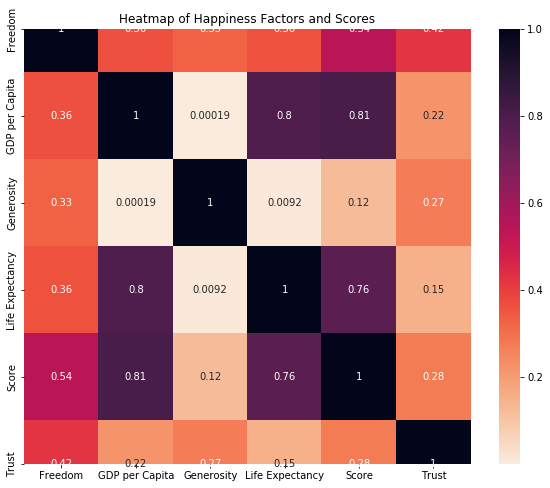

In [38]:
# Create correlation matrix
spearman_cormatrix = data.drop(['Rank', 'Year'], axis=1).corr(method='spearman')

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
happyHeat = sns.heatmap(ax=ax, data=spearman_cormatrix, annot=True, cmap="rocket_r")
happyHeat.set_title("Heatmap of Happiness Factors and Scores")
ax.set_yticklabels(labels=happyHeat.get_yticklabels(), va="center")
happyHeat

### We will now assess how the central tendencies of Happiness Scores have changed over time by first computing some of the central measures of tendency upon grouping the data by year (By Adit Anand).

In [39]:
#25th Percentile
def q25(x):
    return x.quantile(0.25)

#75th Percentile
def q75(x):
    return x.quantile(0.75)

happinessScoreByYear = data.groupby("Year").agg({"Score":["mean", "median", "max", "min", q25, q75, "std"]})
print(happinessScoreByYear)

         Score                                                  
          mean  median    max    min      q25      q75       std
Year                                                            
2015  5.375734  5.2325  7.587  2.839  4.52600  6.24375  1.145010
2016  5.382185  5.3140  7.526  2.905  4.40400  6.26900  1.141674
2017  5.354019  5.2790  7.537  2.693  4.50550  6.10150  1.131230
2018  5.375917  5.3780  7.632  2.905  4.45375  6.16850  1.119506
2019  5.407096  5.3795  7.769  2.853  4.54450  6.18450  1.113120


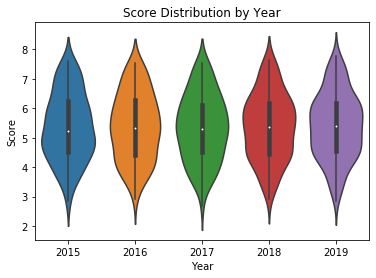

In [40]:
ax = sns.violinplot(x = "Year", y = "Score", data = data).set_title("Score Distribution by Year")

### Since the violin curves look very similar when assessing the distribution of the entirety of the Happiness Scores for 1 year, we will partition the data by the lower-half and upper-half of Happiness Scores and see whether a difference becomes more noticeable (By Adit Anand).

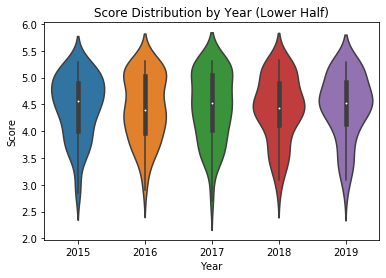

In [41]:
medianScore = data["Score"].median()
lowerHalf = data[data["Score"] <= medianScore]
upperHalf = data[data["Score"] > medianScore]
figLower = sns.violinplot(x = "Year", y = "Score", data = lowerHalf).set_title("Score Distribution by Year (Lower Half)")

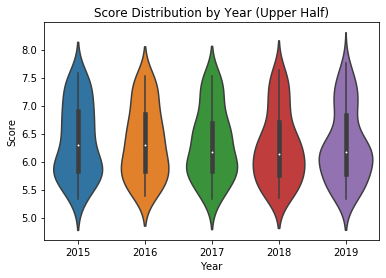

In [42]:
figUpper = sns.violinplot(x = "Year", y = "Score", data = upperHalf).set_title("Score Distribution by Year (Upper Half)")

### Below are the 25 countries with the lowest standard deviations for their Happiness Scores, and thus the most stable ones (though not necessarily the highest ones) (By Adit Anand).

In [43]:
#Limit countries to those with at least 4 years of data reported (approximately one full term)
countryCount = data["Country"].groupby(data["Country"].str.lower()).agg({"count"}).reset_index().sort_values("count")
countriesWithMinYears = countryCount.loc[countryCount["count"] >= 4]
dataForCountriesWithMinYears = data[data["Country"].str.lower().isin(countriesWithMinYears["Country"].tolist())]
countryByScoreStd = dataForCountriesWithMinYears.groupby(dataForCountriesWithMinYears["Country"].str.lower()).agg({"Score":"std"}).sort_values("Score").reset_index()
countryByScoreStd = countryByScoreStd.rename(columns = {"Score":"Score (std)"})
print(countryByScoreStd.nsmallest(25, "Score (std)"))

                    Country  Score (std)
0         trinidad & tobago     0.013145
1                   belgium     0.017743
2               new zealand     0.018221
3                 hong kong     0.021707
4              saudi arabia     0.023896
5                   ecuador     0.024789
6                   iceland     0.028258
7                 australia     0.030890
8   palestinian territories     0.031358
9                   denmark     0.032917
10                   sweden     0.034040
11                    spain     0.035275
12                   norway     0.036069
13               azerbaijan     0.036684
14                    japan     0.037090
15                  ireland     0.043044
16              switzerland     0.043604
17               kazakhstan     0.050880
18                  bolivia     0.052409
19                    china     0.053259
20              netherlands     0.059273
21              south korea     0.060641
22                     peru     0.060818
23              

### Below are the 25 countries that have seen the greatest improvement in their Score from 2015 to 2019 (By Adit Anand).

In [44]:
#This approach does limit the analysis to countries that had records starting in 2015, and thus does not include countries with five years
mostRecentData = dataForCountriesWithMinYears[dataForCountriesWithMinYears["Year"] == 2019]
mostRecentData = mostRecentData[["Country", "Score"]].rename(columns = {"Score":"OldScore"})
oldestData = dataForCountriesWithMinYears[dataForCountriesWithMinYears["Year"] == 2015]
oldestData = oldestData[["Country", "Score"]].rename(columns = {"Score":"NewScore"})
combinedData = pd.merge(mostRecentData.reset_index(), oldestData.reset_index(), on = ["Country"], how = "inner").set_index(["Country"])
combinedData = combinedData[["OldScore", "NewScore"]]
combinedData["scoreDifference"] = combinedData["NewScore"] - combinedData["OldScore"]
print(combinedData.nlargest(25, "scoreDifference"))

                          OldScore  NewScore  scoreDifference
Country                                                      
Venezuela                    4.707     6.810            2.103
Lesotho                      3.802     4.898            1.096
Zambia                       4.107     5.129            1.022
Zimbabwe                     3.663     4.610            0.947
Haiti                        3.597     4.518            0.921
Malawi                       3.410     4.292            0.882
Botswana                     3.488     4.332            0.844
Yemen                        3.380     4.077            0.697
Brazil                       6.300     6.983            0.683
Liberia                      3.975     4.571            0.596
Central African Republic     3.083     3.678            0.595
Mexico                       6.595     7.187            0.592
India                        4.015     4.565            0.550
Tanzania                     3.231     3.781            0.550
Singapor

### Looking at scatter plots, we can see a linear relationship between GDP per Capita and Happiness Scores, Life Expectancy and Happiness Scores, and Freedom and Happiness Scores (By Cesare Lucido).

Text(0.5, 1.0, 'Happiness Score vs. GDP per Capita')

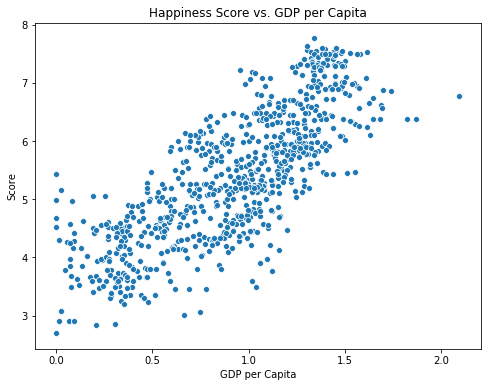

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=data, x="GDP per Capita", y="Score", ax=ax).set_title("Happiness Score vs. GDP per Capita")

Text(0.5, 1.0, 'Happiness Score vs. Life Expectancy')

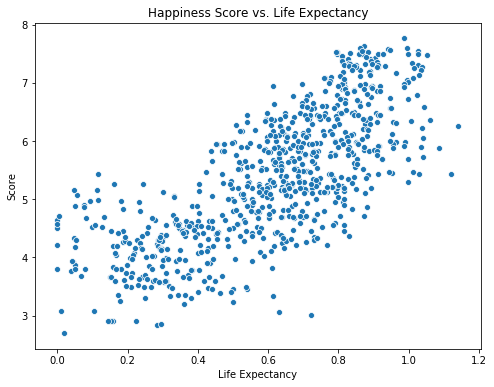

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=data, x="Life Expectancy", y="Score", ax=ax).set_title("Happiness Score vs. Life Expectancy")

Text(0.5, 1.0, 'Happiness Score vs. Freedom')

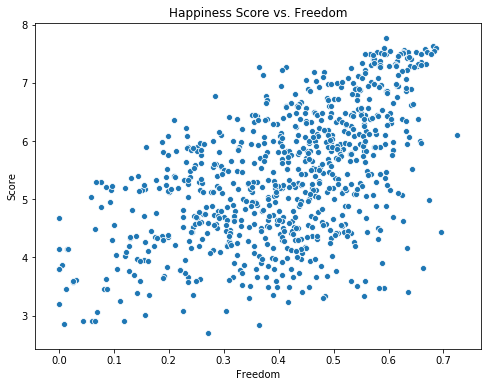

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=data, x="Freedom", y="Score", ax=ax).set_title("Happiness Score vs. Freedom")

### Here we examine the change in mean statistics between each year. From 2015-2019, we see an increase in life expectancy and GDP per capita. Conversely, we see a decrease in Freedom, Trust, and Generosity. (By Cesare Lucido).

In [48]:
data.groupby("Year").mean()

,Freedom,GDP per Capita,Generosity,Life Expectancy,Rank,Score,Trust
Year,,,,,,,
2015,0.428615,0.846137,0.237296,0.630259,79.493671,5.375734,0.143422
2016,0.370994,0.953880,0.242635,0.557619,78.980892,5.382185,0.137624
2017,0.408786,0.984718,0.246883,0.551341,78.000000,5.354019,0.123120
2018,0.454506,0.891449,0.181006,0.597346,78.500000,5.375917,0.113282
2019,0.392571,0.905147,0.184846,0.725244,78.500000,5.407096,0.110603


# Modeling and Question Answering) 

### In order to predict rankings in 2019, we will first split the data into testing and training sets (By Cesare Lucido). 

In [49]:
training = data[data["Year"] != 2019]
testing = data[data["Year"] == 2019]

### The first model will use a simple Linear Regression to predict the scores of each country in 2019. Then, after assigning ranks based on the predicted scores, we will compare to the actual rankings in 2019 (By Cesare Lucido).

In [50]:
regressor = LinearRegression() # Create LinearRegression object
x_train = training[['GDP per Capita', 'Life Expectancy', 'Freedom']].values # get training data 
y_train = training["Score"].values # get training data 
regressor.fit(x_train, y_train) # fit the data into a model

x_test = testing[['GDP per Capita', 'Life Expectancy', 'Freedom']].values # get training data 
y_test = testing["Rank"].values # get actual ranks
y_pred = regressor.predict(x_test) # predict scores

result = pd.DataFrame({'Country': testing["Country"].values, 'Predicted': y_pred, 'Actual': y_test})
result["Predicted"] = result["Predicted"].rank(ascending=False) # Create ranking for predicted scores 
result.sort_values(by=["Predicted"], inplace=True) # Sort by predicted rank
result

,Country,Predicted,Actual
33,Singapore,1.0,34
2,Norway,2.0,3
13,Luxembourg,3.0,14
28,Qatar,4.0,29
5,Switzerland,5.0,6
...,...,...,...
146,Haiti,152.0,147
144,Burundi,153.0,145
153,Afghanistan,154.0,154
155,South Sudan,155.0,156


### We calculate the r^2 score and root mean squared error after predicting the ranks.

In [51]:
y_pred = result["Predicted"]
y_test = result["Actual"]
print('R^2 Score:', metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R^2 Score: 0.7570577357715225
Mean Absolute Error: 16.705128205128204
Mean Squared Error: 492.6666666666667
Root Mean Squared Error: 22.19609575278199


### For our second model, we will use a K-Nearest-Neighbors Regression. According to the sklearn documentation, this algorithm assigns a query point based on the mean of the labels of its nearest neighbors. After fitting the training data, we will predict rankings for 2019 (By Cesare Lucido).

In [52]:
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(x_train, y_train)

x_test = testing[['GDP per Capita', 'Life Expectancy', 'Freedom']].values # get training data 
y_test = testing["Rank"].values # get actual ranks
y_pred = neigh.predict(x_test) # predict scores

result = pd.DataFrame({'Country': testing["Country"].values, 'Predicted': y_pred, 'Actual': y_test})
result["Predicted"] = result["Predicted"].rank(ascending=False) # Create ranking for predicted scores 
result.sort_values(by=["Predicted"], inplace=True) # Sort by predicted rank
result

,Country,Predicted,Actual
20,United Arab Emirates,1.0,21
28,Qatar,2.0,29
50,Kuwait,3.0,51
0,Finland,4.0,1
1,Denmark,5.0,2
...,...,...,...
153,Afghanistan,152.0,154
154,Central African Republic,153.0,155
131,Chad,154.0,132
155,South Sudan,155.0,156


### We calculate the r^2 score and root mean squared error after predicting the ranks. Relative to our linear regression model, this model performed slightly worse.

In [53]:
y_pred = result["Predicted"]
y_test = result["Actual"]
print('R^2 Score:', metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R^2 Score: 0.7025999272968659
Mean Absolute Error: 18.705128205128204
Mean Squared Error: 603.1025641025641
Root Mean Squared Error: 24.55814659339267


### The third model will use a Ridge Regression to predict the scores of each country in 2019. Then, after assigning ranks based on the predicted scores, we will compare to the actual rankings in 2019 (By Adit Anand).

In [54]:
ridgeRegressor = Ridge(alpha=1.0)
ridgeRegressor.fit(x_train, y_train)
x_test = testing[['GDP per Capita', 'Life Expectancy', 'Freedom']].values # get training data 
y_test = testing["Rank"].values # get actual ranks
y_pred = ridgeRegressor.predict(x_test)

result = pd.DataFrame({'Country': testing["Country"].values, 'Predicted': y_pred, 'Actual': y_test})
result["Predicted"] = result["Predicted"].rank(ascending=False) # Create ranking for predicted scores 
result.sort_values(by=["Predicted"], inplace=True) # Sort by predicted rank
result

,Country,Predicted,Actual
33,Singapore,1.0,34
2,Norway,2.0,3
13,Luxembourg,3.0,14
28,Qatar,4.0,29
5,Switzerland,5.0,6
...,...,...,...
146,Haiti,152.0,147
144,Burundi,153.0,145
153,Afghanistan,154.0,154
155,South Sudan,155.0,156


### We calculate the r^2 score and root mean squared error after predicting the ranks. Relative to our linear regression model, this model performed slightly better.

In [55]:
y_pred = result["Predicted"]
y_test = result["Actual"]
print('R^2 Score:', metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R^2 Score: 0.7585876625942375
Mean Absolute Error: 16.67948717948718
Mean Squared Error: 489.56410256410254
Root Mean Squared Error: 22.1260955110499
